# T7 - Calibration

Tutorial 2 demonstrated how to run the model and plot the outputs. But it's entirely possible that the model outputs won't look like the data for the country that you wish to model. The default parameter values included in HPVsim are intended as points of departure to be iteratively refined via calibration. The process of model calibration involves finding the model parameters that are the most likely explanation for the observed data. This tutorial gives an introduction to the Fit object and some recipes for optimization approaches.

<div class="alert alert-info">
    
Click [here](https://mybinder.org/v2/gh/institutefordiseasemodeling/hpvsim/HEAD?urlpath=lab%2Ftree%2Fdocs%2Ftutorials%2Ftut_calibration.ipynb) to open an interactive version of this notebook.
    
</div>

## Data types supported by HPVsim

Data on HPV and cervical disease comes in many different formats. When using HPVsim, the goal is typically to produce population-level estimates of epidemic outputs like:
    - age-specific incidence of cancer or high-grade lesions in one or more years;
    - number of cases of cancer or high-grade lesions reported in one or more years;
    - HPV prevalence over time;
    - lifetime incidence of HPV;
    - the distribution of genotypes in detected cases of cancer/high-grade lesions;
    - sexual behavior metrics like the average age at first marriage, duration of relationships, or number of lifetime partners.

After running HPVsim, estimates all of these variables are included within the `results` dictionary. To plot them alongside data, the easiest method is to use the `Calibration` object.


## The Calibration object

Calibration objects contain the following ingredients:
    - an `hpv.Sim()` instance with details of the model configuration;
    - two lists of parameters to vary, one for parameters that vary by genotype and one for those that don't;
    - dataframes that hold the calibration targets, which are typically added as csv files;
    - a list of any additional results to plot;
    - settings that are passed to the Optuna package[LINK], an open source hyperparameter optimization framework that automates calibration for HPVsim.

We have included Optuna as a built-in calibration option as we have found that it works reasonably well, but it is also possible to use other methods; we will discuss this a little further down.

The example below illustrates the general idea of calibration, and can be adapted for different use cases:

In [ ]:
# Import HPVsim
import hpvsim as hpv

# Configure a simulation with some parameters
pars = dict(n_agents=10e3, start=1980, end=2020, dt=0.25, location='nigeria')
sim = hpv.Sim(pars)

# Specify some parameters to adjust during calibration.
# The parameters in the calib_pars dictionary don't vary by genotype,
# whereas those in the genotype_pars dictionary do. Both kinds are
# given in the order [best, lower_bound, upper_bound].
calib_pars = dict(
        beta=[0.05, 0.010, 0.20],
    )

genotype_pars = dict(
    hpv16=dict(
        sev_fn=dict(k=[0.5, 0.2, 1.0]),
        dur_episomal=dict(par1=[6, 4, 12])
    ),
    hpv18=dict(
        sev_fn=dict(k=[0.5, 0.2, 1.0]),
        dur_episomal=dict(par1=[6, 4, 12])
    )
)

# List the datafiles that contain data that we wish to compare the model to:
datafiles=['nigeria_cancer_cases.csv',
           'nigeria_cancer_types.csv']

# List extra results that we don't have data on, but wish to include in the
# calibration object so we can plot them.
results_to_plot = ['cancer_incidence', 'asr_cancer_incidence']

# Create the calibration object, run it, and plot the results
calib = hpv.Calibration(
    sim,
    calib_pars=calib_pars,
    genotype_pars=genotype_pars,
    extra_sim_result_keys=results_to_plot,
    datafiles=datafiles,
    total_trials=3, n_workers=1
)
calib.calibrate(die=True)
calib.plot(res_to_plot=4);

This isn't a great fit yet! In general, it will probably be necessary to run many more trials that the 3 we ran here. Moreover, careful consideration should be given to the parameters that you want to adjust during calibration. In HPVsim we have taken the approach that any parameter can be adjusted. As we learn more about which parameters make most sense to calibrate, we will add details here. We would also enourage users to share their experiences with calibration and parameter searches.

In [ ]:
!pip install pyDOE
!pip install xgboost
!pip install sklearn

In [1]:
from tests.test_precalib_exploration import *

HPVsim 1.2.2 (2023-07-12) — © 2023 by IDM


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#%% Configure a simulation with some parameters. If you already have .obj file, you could read sim from there
location ='india'
pars = dict(n_agents=10e3, start=1980, end=2020, n_years=40, location=location, verbose=0)
sim = hpv.Sim(pars)
sim.run()
default_pars = sim.pars

# Read all input parameters from sim and save to csv. Custom fill parameters' lower and upper bounds.
param_space = get_all_param_space(default_pars)
param_space.to_csv('param_space.csv')

Loading location-specific demographic data for "india"


In [3]:
#%% When the lower and upper bound 
# Read user-defined param space and define a calibration space. 
custom_param_space, calib_space = get_calib_space('param_space_filled.csv', ['Assume'])

# Set calibration settings
# Read target data. The data value consists of lower and upper bound
datafiles = [
    f'test_data/{location}_hpv_prevalence.csv',
    f'test_data/{location}_cancer_cases.csv',
    f'test_data/{location}_cin1_types.csv',
    f'test_data/{location}_cin3_types.csv',
    f'test_data/{location}_cancer_types.csv',
]
total_trials = 20 #number of total lhs samples
n_workers = 8 # number of CPUs
name = f'precalib_{location}'
save_results = True

# Finally, run calibration
run_precalib_exploration(location, datafiles, default_pars, custom_param_space, calib_space, total_trials, n_workers, name, save_results)

Loading location-specific demographic data for "india"


[I 2023-09-05 17:00:39,058] A new study created in RDB with name: precalib_india


Could not delete study, skipping...
'Record does not exist.'
Removed existing calibration precalib_india.db


/Users/serinlee/Library/CloudStorage/GoogleDrive-serinlee@uw.edu/My Drive/Reserach Project/2023_Gates Foundation Summer/hpvsim/hpvsim/sim.py:810: RuntimeWarning: overflow encountered in cast
  foi = (1 - (foi_whole * foi_frac)).astype(hpd.default_float)
[I 2023-09-05 17:00:50,913] Trial 1 finished with value: 9.997343010337364 and parameters: {'acts_c_par1': 11.28935913948958, 'acts_c_par2': 3.7289756024013063, 'acts_m_par1': 76.73370317347101, 'acts_m_par2': 48.86736417050467, 'acts_o_par1': 1.1945647447837435, 'acts_o_par2': 0.005250209833512049, 'age_act_pars_c_debut_ratio': 0.5435388968579484, 'age_act_pars_c_peak': 29.528411613990187, 'age_act_pars_c_retirement': 119.04258702783271, 'age_act_pars_c_retirement_ratio': 0.05373915366069599, 'age_act_pars_m_debut_ratio': 0.5814887962293005, 'age_act_pars_m_peak': 22.854411041793522, 'age_act_pars_m_retirement': 133.7692132593226, 'age_act_pars_m_retirement_ratio': 0.08325566812552748, 'age_act_pars_o_debut_ratio': 0.45871698944543515,

Loading saved results...
    Removed temporary file tmp_calibration_00000.obj
  Loaded trial 0
    Removed temporary file tmp_calibration_00001.obj
  Loaded trial 1
    Removed temporary file tmp_calibration_00002.obj
  Loaded trial 2
    Removed temporary file tmp_calibration_00003.obj
  Loaded trial 3
    Removed temporary file tmp_calibration_00004.obj
  Loaded trial 4
    Removed temporary file tmp_calibration_00005.obj
  Loaded trial 5
    Removed temporary file tmp_calibration_00006.obj
  Loaded trial 6
    Removed temporary file tmp_calibration_00007.obj
  Loaded trial 7
    Removed temporary file tmp_calibration_00008.obj
  Loaded trial 8
    Removed temporary file tmp_calibration_00009.obj
  Loaded trial 9
    Removed temporary file tmp_calibration_00010.obj
  Loaded trial 10
    Removed temporary file tmp_calibration_00011.obj
  Loaded trial 11
    Removed temporary file tmp_calibration_00012.obj
  Loaded trial 12
    Removed temporary file tmp_calibration_00013.obj
  Loaded 

In [4]:
#%% Analyze the results
# Read calibration results and organize the results
calib = sc.load(f'results/{name}.obj')
custom_param_space, calib_space  = get_calib_space('param_space_filled.csv', ['Assume'])
result_df = organize_results(calib, calib_space)

# Now analyze the parameter importance using machine learning. Current version supports LinearRegression, RandomForest, and XGBoost
param_cols = calib_space['names']
X = result_df[param_cols]
Y = result_df[result_df.columns.difference(param_cols+['index'])]
param_importance = fit_model('RandomForest', X, Y)

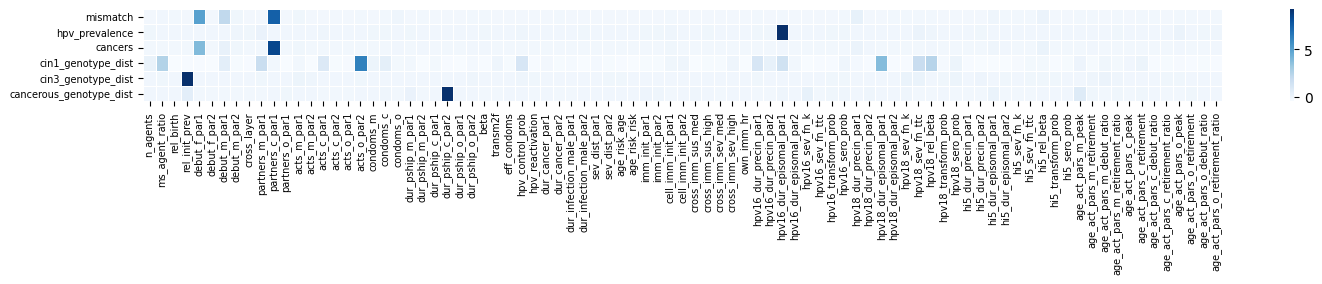

In [5]:
# %%Plot results. Users can specify the outcome level 0 to 2
outcomes = get_interest_outcome(Y, outcome_level=1)
heatmap(param_importance, outcomes, save_plot = False)

In [ ]:
outcomes = ['hpv_prevalence']
heatmap(param_importance, outcomes, save_plot = False)

In [ ]:
How to solve some errors